Things to test:
- Smaller window (2-3 coulomb peak)
  Z[50:150, 20:120]. If it has a transition, check that it still finds a transition
  -> This works pretty good but determining the gradient becomes more uncertain.
- Lower resolution (e.g.60x60 points, decimation)
  Z[20:120:5, 20:120:5] Adds a 5x decimation (only use every 5th)
- Add noise
  Z + alpha *np.random.uniform(Z.size) adds noise with magnitude alpha
  
Feel free to combine multiple tests

FILTERING DISCUSSION:
Filtering Z prior seems to lose information but also could really help mitigate noise.
Filtering theta seems to help increase contrast in transiion gradient matrices. 
Filtering transition gradient matrices doesn't seem to be good for anything at the moment... but we'll see, i won't rule it out.

Deleting transitions needs to fully black out transitions for proper operation. Additionally, crossing transitions need to be accounted for.
Transgrad needs to be calculated more carefully. 


Plan:
- do the todo and add more explainations
- Make a function to test sweeps and display it nicely
  Ideal function:
  - Input: X, Y, Z, data
  - Output: slope of transition(s) while varying gate (Z)

- test this on new test data

- If time, use capacitance matrix to find location of the donor.

In [11]:
import qcodes as qc
import numpy as np
from scipy import signal
conv2 = signal.convolve2d
peaks = signal.find_peaks

import detect_peaks
from importlib import reload
reload(detect_peaks )
from detect_peaks import *

In [2]:
#qc.data.data_set.DataSet.default_io.base_location = r'/Users/Dennis/Documents/Uni/ThesisB/Jupyter'
data = qc.load_data('CSD/2018-03-26/#004_4D_DC_TGAC_DBL_DBR_14-51-19')
data

DataSet:
   location = 'CSD/2018-03-26/#004_4D_DC_TGAC_DBL_DBR_14-51-19'
   <Type>   | <array_id>          | <array.name> | <array.shape>
   Setpoint | DC_control_DFR_set  | DFR          | (3,)
   Setpoint | DC_control_DFL_set  | DFL          | (3, 3)
   Setpoint | DBL_DBR_set         | DBL_DBR      | (3, 3, 301)
   Setpoint | DC_control_TGAC_set | TGAC         | (3, 3, 301, 251)
   Measured | DC_voltage          | DC_voltage   | (3, 3, 301, 251)

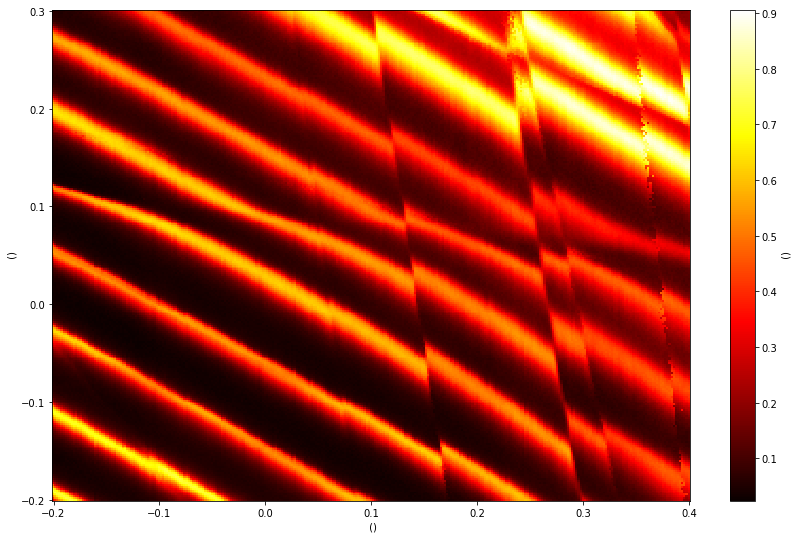

In [3]:
# importing data
x = data.DBL_DBR_set[1,1,:]
y = data.DC_control_TGAC_set[1,1,1,:]
Z = data.DC_voltage[1,0,:,:] #change these values for different datasets
#00 none 
#01 one clear
#02 three clear
#10 four clear
#11 five messy
#12 seven ok clarity. See this one for two transitions crossing clearly
#20 five messy at end
#21 six messy
#22 seven clearish
Z = np.swapaxes(Z,0,1)
    
#reduced sample size
#still works fine at locating, but determining gradient becomes less accurate
#x = x[145:250]
#y = y[125:251]
#Z = Z[125:251,145:250]

# decimation
#works fine locating up to 3x decimation. gradient becomes less accurate
#dec = 3;
#x = x[0:300:dec] 
#y = y[0:250:dec]
#Z = Z[0:250:dec,0:300:dec]

#Add noise
#filtering does clear this up BUT this outlines an issue with calculating transgrad.
#transgrad needs to take into account the relative maximums. otherwise noise greatly interferes. Improving transgrad
#calculations will make the system much more reliable
#alpha = 0.05
#Z = Z + alpha*np.random.uniform(-1,1,size=Z.shape)

plot = qc.MatPlot(Z,x=x,y=y,  figsize=(12,8))
#0.408
#0.203 #0.367 on 20 due to scanning error
#seems to work better in the centre of the image
#nonetheless, this works fully on all sample data. I hope it is not very overfitted

[{'gradient': -7.0,
  'gradient_error': 2.8594771241830017,
  'intensity': 0.86303854875283437,
  'location': 186},
 {'gradient': -6.8055555555555554,
  'gradient_error': 2.7799227799227721,
  'intensity': 0.79455782312925161,
  'location': 248},
 {'gradient': -5.2127659574468082,
  'gradient_error': 2.128623188405804,
  'intensity': 0.78820861678004539,
  'location': 267},
 {'gradient': -11.136363636363637,
  'gradient_error': 4.554865424430643,
  'intensity': 0.67392290249433107,
  'location': 296}]

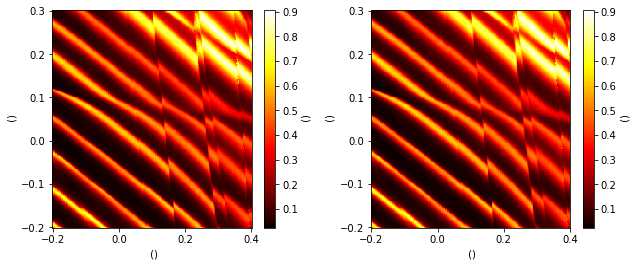

In [37]:
#%%timeit
#use this to find transitions
reload(detect_peaks )
from detect_peaks import*
transitions = find_transitions(Z,x,y, true_units=False, charge_transfer=False, plot='Simple')
transitions

#timing done with 0,2
#2.94s reduced calc_transgrad
#3.38s reduced delete_trans
#4.09s reduced transgrad range
#8.16s full range
#-8.3, -8.89, -5.93

In [22]:
%%timeit
ans = get_charge_transfer_information(
                Z, transitions[0]['location'], transitions[0]['gradient'], theta_mode)
#9.95 ms ± 369 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

9.95 ms ± 369 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


array([ 0.86303855,  0.06062748])

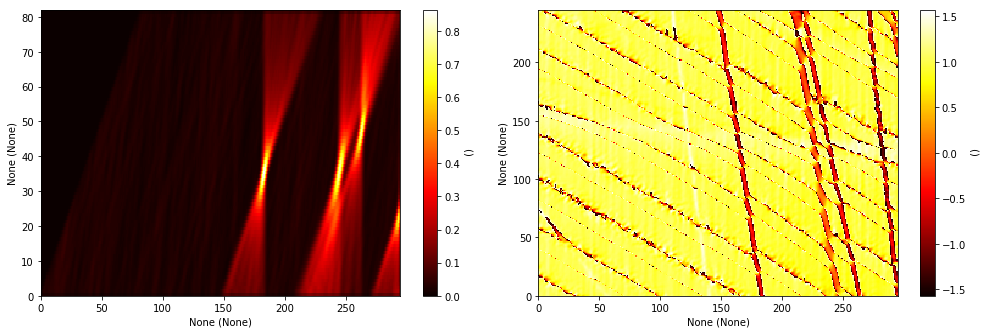

In [21]:
#use this to demonstrate how the program works
theta = calculate_theta_matrix(Z, filter=True)
theta_mode = find_matrix_mode(theta)
transgrad = calculate_transition_gradient(theta)
qc.MatPlot(transgrad, theta, figsize=(14,5))
np.array([np.max(transgrad), np.mean(transgrad)])

In [ ]:
#run this multiple times to step through the process
I = max_index(transgrad)
location = I[1]
gradient = I[0]
theta = delete_trans(theta, location, gradient)
transgrad = calc_transgrad(theta)
plot = qc.MatPlot(transgrad, theta, figsize=(14,5))
np.array([np.max(transgrad), np.mean(transgrad)])


In [ ]:
## Use this to generate test sweep data
Z = np.swapaxes(data.DC_voltage[1,0,:,:],0,1)
x1 = 120
x2 = 250
n = 10
Z_s = np.zeros((n,125,x2-x1))
x_s = x[x1:x2]
y_s = y[125:250]
for i in range(n):
    #np.append((Z_sweep,Z[125:250,x1:x2]),axis=0)
    Z_s[i,:,:] = Z[125:250,x1:x2]
    qc.MatPlot(Z_s[i,:,:], figsize=(5,5))
    x1 = x1+3
    x2 = x2+3

#00 none 
#01 one clear
#02 three clear
#10 four clear
#11 five messy
#12 seven ok clarity. See this one for two transitions crossing clearly
#20 five messy at end
#21 six messy
#22 seven clearish

# n = 3
# Z_s = np.zeros((n,251,301))
# x_s = x
# y_s = y
# for i in range(n):
#     #take a look at 2,i, looks pretty cool. i,2 has some cool ones too.
#     Z_s[i,:,:] = np.swapaxes(data.DC_voltage[2,i,:,:],0,1)
#     qc.MatPlot(Z_s[i,:,:], figsize=(8,5))
    

In [ ]:
#get a better name for M
n_s = Z_s.shape[0]
n_x     = Z_s.shape[2]
#first axis is sweep
#second axis is start position
#value stored is gradient
#this needs to be expanded for multiple gradients at same location

M = np.zeros((n_s,n_x))
for i in range(n_s):
    transitions = find_transitions(Z_s[i,:,:],x_s,y_s)
    for k in range(len(transitions)):
        M[i,transitions[k]['location']] = transitions[k]['gradient']

In [ ]:
qc.MatPlot(M, figsize=(8,5))

In [31]:
reload(detect_peaks )
from detect_peaks import*

In [ ]:
def find_transitions(Z, x, y, trueunits=False, chargetransfer=False, plots=False):
    """
    Function that locates transitions within a 2-dimensional charge stability diagram 
    and returns relevant information.

    Args:
        Z  (numpy.ndarray): 2-dimensional charge stability diagram matrix.
        x  (numpy.ndarray): 1-dimensional voltage vector for the x-axis of Z
        y  (numpy.ndarray): 1-dimensional voltage vector for the y-axis of Z
        trueunits (bool): 
            if(True):
                Where applicable, return all values in proper units. i.e. voltage and current.
            if(False):
                Return values in calculation specific form. i.e. index and ratios.
        chargetransfer (bool):
            Enables calculation of voltage and current shift information about transitions.
            This is required to calculate dV, dI, dI_x, dI_y
        plots (bool):
            Enables plotting of theta and transition gradient diagrams for each transition found.

    Returns: an array of dictionaries, one entry for each transition found:
    if(trueunits == True):
        location  (float): Voltage at the base of the transition.
        gradient  (float): Gradient of the transition. in y_Voltage/x_Voltage
        intensity (float): Value between 0 and 1, indicating the strength of the transition
        dV        (float): The shift of coulomb peaks from a charge transfer event. dV = dVtop = ∆q/Ctop
        dI        (array): An array of current change from before to after a transition.
                           Returns -1 if error.
        dI_x      (array): An array of x-voltages corresponding to the points in dI.
        dI_y      (array): An array of y-voltages corresponding to the points in dI.
    if(trueunits == False):
        location    (int): Index at the base of the transition.
        gradient  (float): Gradient of the transition. in y-index/x-index
        intensity (float): Value between 0 and 1, indicating the strength of the transition
        dV          (int): The shift of coulomb peaks from a charge transfer event in terms of index in X. 
                           dV*(y[1]-y[0]) = dVtop = ∆q/Ctop
        dI        (array): An array of current change from before to after a transition.
                           Returns -1 if error.
        dI_x      (array): An array of x-indices corresponding to the points in dI.
        dI_y      (array): An array of y-indices corresponding to the points in dI.
    """

    theta = calc_theta(Z, filter=True)
    theta_mode = find_mode(theta)
    transgrad = calc_transgrad(theta)
    if(plots): 
        qc.MatPlot(transgrad, theta, figsize=(14,5))

    translist = []
    
    #First condition was max >0.4
    #Second condition is max > 5*mean


    while((np.max(transgrad) > 3*np.mean(transgrad)) & (np.max(transgrad) >0.3)):
        
        I = max_index(transgrad)
        M = np.max(transgrad)
    
        difx = (x.shape[0]-theta.shape[1])/2
        dify = (y.shape[0]-theta.shape[0])/2
        location = (difx +I[1] +np.around(dify*I[0]/theta.shape[0])).astype(int)
        theta = delete_trans(theta, I[1], I[0])
        transgrad = calc_transgrad(theta)
        
        if(I[0] >3):
            gradient = -(theta.shape[0]/I[0])
            gradient_error = (np.abs(I[0]/(I[0]-1)-1) + np.abs(I[0]/(I[0]+1)-1))*50 # same as*100/2
        else:
            #this is for if we try to divide by zero. i.e. gradient is infinity 
            #The gradient will never be this so it will be false read and we can pass over it.
            continue
        
        if (trueunits): #this makes all the values in actual units, not just indices
                #units in V/V
            gradient = gradient*(y[1]-y[0])/(x[1]-x[0]) #in V/V
                #units in V
            location = x[location]
        
        
        if(chargetransfer):
            #dV = dVtop = ∆q/Ctop
            dV, dI, dI_x, dI_y = get_chargetransfer(Z, location, gradient, theta_mode)
            
            if (trueunits): #this makes all the values in actual units, not just indices
                    #units in V
                dV = dV*(y[1]-y[0])
                    #units in V
                dI_y = y[dI_y]
                    #units in V
                dI_x = x[dI_x]
            trans = {'location' : location, 'gradient': gradient,\
                     'grad_err%' : gradient_error, 'intensity' : M, 'dVtop' : dV,\
                     'dI_y' : dI_y, 'dI_x' : dI_x, 'dI' : dI}
        else:
            trans = {'location' : location, 'gradient': gradient,\
                     'grad_err%' : gradient_error, 'intensity' : M}

        translist.append(trans)
        
        if(plots):
            qc.MatPlot(transgrad, theta, figsize=(14,5))
        
    return translist

In [ ]:
def get_chargetransfer(Z, location, gradient, theta_mode):
    """
    A function that calculates information about a particular charge transfer event.
    dI information pertains to points on a coulomb peak prior to a charge transfer event.

    Args:
        Z  (numpy.ndarray): 2-dimensional charge stability diagram matrix.
        location     (int): Base index of the charge transfer event in Z
        gradient   (float): Gradient of the charge transfer event in Z
        theta_mode (float): Mode of theta (most common theta value)

    Returns:
        dV     (int): The shift of coulomb peaks from a charge transfer event. 
                      Given as a shift of index in Z. When properly scaled:
                          dV = dVtop = ∆q/Ctop
        dI   (array): An array of current change from before to after a transition.
        dI_x (array): An array of x-indices corresponding to the points in dI.
        dI_y (array): An array of y-indices corresponding to the points in dI.
    """
    
    ly = Z.shape[0]
    yl = np.linspace(0, ly, ly, endpoint=False, dtype=int)#.ravel()  #<<< check out if that works
    yl = yl.ravel()
    xl = (location + np.around(yl/gradient)).astype(int);
    
    try:
            #lines to check before and after
        shift = 3
        line_pre = Z[yl,xl -shift]
        line_pos = Z[yl,xl +shift]
        #average magnitude difference function
        AMDF = np.zeros(ly)
        for i in range(ly):
            #AMDF[i] = np.mean(np.abs(np.around(np.cos(peak-theta[yl,xl])**2)))
            AMDF[i] = -np.mean(np.abs(line_pre[np.array(range(0,ly-i))] -line_pos[np.array(range(i,ly))]))*(ly+i)/ly
            
        # the 7 in the following line is from the 1 +2*reach of the pos/pre lines
        #qc.MatPlot(AMDF, figsize=(14,5))
        peakshift = np.around(np.abs(np.tan(theta_mode-np.pi/2))*(1+2*shift)).astype(int)
        dV = max_index(AMDF)[0] + peakshift
        
        shift = 1
        line_pre = Z[yl,xl -shift]
        line_pos = Z[yl,xl +shift]
        
        #this peak detection could DEFINITELY be fine-tuned (check back for how dI is calculated tooooo)
        #i did it very quick sticks
        #11pm on a saturday night
        #yes, that quick
        peaks = (signal.find_peaks(line_pre -line_pos, distance=25, height=0.2))
        dI_y = peaks[0]
        dI_x = (location + np.around(dI_y/gradient)).astype(int);
        dI = peaks[1]['peak_heights']
        
        return dV, dI, dI_x, dI_y
    except:
        return -1,-1,-1,-1